### Basic ISC

The goal of this notebook is to run a simple overall ISC (across the whole sample) to establish comparability with the older partly-cloudy study (Boston, USA). To this end, we'll quickly reproduce the old study's basic ISC results. Note, however, that the study had some differences: The MRI parameters differed (TR -- hence, different lenght), the movie was possibly cut slightly differently, and we had used only a 268-parcellation (Shen), whereas the current, newer data made use of a 293-region parcellation (that does, however, include the Shen-regions as regions 1-268 --- and  amends them with subcortical regions).

#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle
import sys
sys.path.insert(1, '../')
from nilearn import plotting, maskers, datasets
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, threshold, fdr
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from tqdm import tqdm
from utils import *
import warnings
warnings.simplefilter("ignore")

#### Setup variables and filenames

In [2]:
recompute_results      = True
pairwise_flag          = True
n_iter                 = 1000
alpha                  = 0.05
fmri_data_file         = '../../data/03_extract_ts_usa/usa_ts_array_shen268_regional_average_ages13-99.npy'
all268_rois_file       = '../../data/02_rois_masks_maps/shen_2mm_268_parcellation.nii'
masker_prefitting_file = '../../data/02_rois_masks_maps/maskerprefit_bold.nii.gz'

isc_result_file_phase  = '../../data/05_results/usa_isc_phase1000FDRq05.nii'
isc_result_file_perm   = '../../data/05_results/usa_isc_perm1000_FDRq05.nii'
isc_npy_file           = '../../data/05_results/usa_isc_perm1000_FDRq05.npy'

#### Set up masker, load timeseries

In [3]:
# prepare masker
isc_masker = maskers.NiftiLabelsMasker(all268_rois_file);
isc_masker.fit(masker_prefitting_file);
print("Set up ISC masker")

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data = np.swapaxes(ts_array, 0, 2)
ts_data = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

Set up ISC masker
Shape of time series structure: (168, 268, 33)


#### Basic ISC analysis 
(via resampling stats)

100%|█████████████████████████████████████████| 268/268 [01:05<00:00,  4.09it/s]


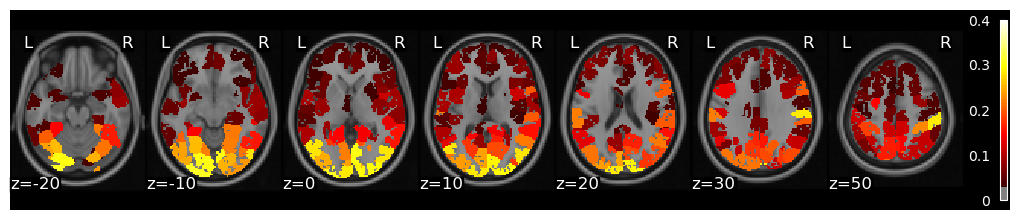

In [4]:
# set up mask
mask = Brain_Data(all268_rois_file)
mask_x = expand_mask(mask)

# run isc permutation/bootstrap analysis
p_results = []
isc_results = []
for curr_roi in tqdm(range(268)):
    #print(curr_roi)
    data_roi_df = pd.DataFrame(ts_data[:,curr_roi,:] )
    stats_boot = isc(data_roi_df, method='bootstrap', n_samples=5000, return_null=True)
    #print(f"ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    p_results.append(stats_boot['p'])
    isc_results.append(stats_boot['isc'])

# map isc results back to brain
isc_r_brain, isc_p_brain = roi_to_brain(pd.Series(isc_results), mask_x), roi_to_brain(pd.Series(p_results), mask_x)
result_image = threshold(isc_r_brain, isc_p_brain, thr=fdr(isc_p_brain.data, q = alpha)).to_nifti()

# visualize results
fig = plt.figure(figsize=(10, 2))
nilearn.plotting.plot_stat_map(    result_image, 
                                   bg_img='../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03,  #additional threshold for visualization
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ -20, -10, 0, 10, 20, 30, 50],
                                   annotate     = True,
                                   figure = fig);


#### Compute and Plot ISC 
(via phase randomization method from BrainIAK)

Now computing phaseshift ISC ...


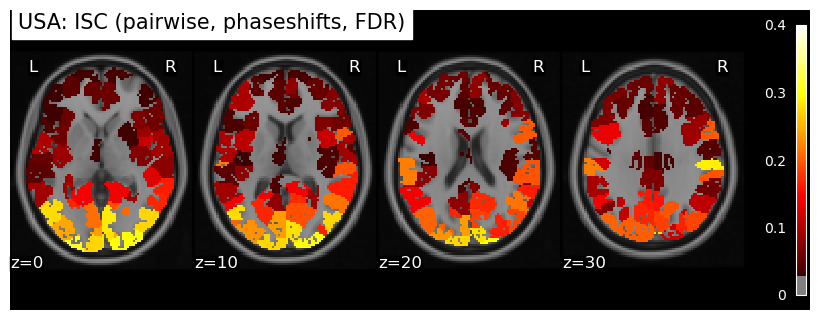

In [5]:
if recompute_results:
    
    # submit to ISC analysis, takes about 15-20 minutes on normal machine with 1000 shifts
    print('Now computing phaseshift ISC ...')
    ISC, p = partly_phaseshift_isc(ts_data, pairwise = pairwise_flag, summary_statistic = np.mean,
                                    n_shifts = n_iter, return_distribution = False)
    ISC[np.isnan(ISC)] = 0
    
    # Stats correction 
    q                               = multipletests(p[0, :], method='fdr_by')[1]
    corrected                       = q[np.newaxis, :] < alpha
    ISC[corrected == False]         = 0

    # Map to brain space
    curr_isc = np.reshape(ISC, (268,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_phase)

else:
    curr_img = nilearn.image.load_img(isc_result_file_phase)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                   bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                   threshold    = 0.03, 
                                   vmax         = 0.4, 
                                   draw_cross   = False,
                                   display_mode = 'z',
                                   cut_coords   = [ 0, 10, 20, 30],
                                   annotate     = True,
                                   title = 'USA: ISC (pairwise, phaseshifts, FDR)',
                                   figure = fig);
plt.show();

#### Compute and Plot ISC 
(via permutation method from BrainIAK)

Assuming 33 subjects with 168 time points and 268 voxel(s) or ROI(s).
Now computing permutation ISC ...


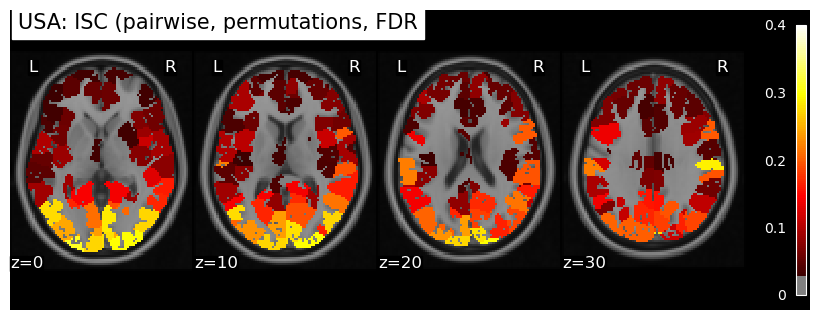

In [6]:
if recompute_results:
    
    # first, compute the individual isc and flatten into a one-subject-per-line matrix 
    input_isc = partly_isc(ts_data, pairwise=True, summary_statistic=None)
    
    # Compute permutation ISC
    print('Now computing permutation ISC ...')
    ISC, p, distribution = partly_permutation_isc(input_isc, pairwise= True, summary_statistic = 'mean', n_permutations = n_iter)
    
    # Correction 
    p = np.reshape(p, (268,1)).T
    ISC[np.isnan(ISC)]      = 0
    q                       = multipletests(p[0, :], method='fdr_by')[1]
    corrected               = q[np.newaxis, :] < alpha
    ISC[corrected == False] = 0

    # Map statistical results into brain space
    curr_isc = np.reshape(ISC, (268,1)).T
    curr_img = isc_masker.inverse_transform(curr_isc);
    curr_img.to_filename(isc_result_file_perm)
    np.save(isc_npy_file, curr_isc)

else:
    curr_img = nilearn.image.load_img(isc_result_file_perm)

# Plot
fig = plt.figure(figsize=(8, 3))
nilearn.plotting.plot_stat_map(nilearn.image.index_img(curr_img,0), 
                                       bg_img       = '../../data/02_rois_masks_maps/MNI152_T1_2mm.nii.gz',
                                       threshold    = 0.03, 
                                       vmax         = 0.4, 
                                       draw_cross   = False,
                                       display_mode = 'z',
                                       cut_coords   = [ 0, 10, 20, 30],
                                       annotate     = True,
                                       title = 'USA: ISC (pairwise, permutations, FDR',
                                       figure = fig);
plt.show();